## Exponential Smoothing 

### Import Libraries

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *


### Load Dataset

- Loading excel file

In [4]:
spark = SparkSession.builder \
    .appName("Exponential Smoothing") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .getOrCreate()

data = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("./dataset/test.xlsx")

In [5]:
data.show(5)

+-----------+----------+-------+-------+
|month_bs_id|account_id|txn_amt|txn_cnt|
+-----------+----------+-------+-------+
|     9811.0|     868.0|  500.0|    1.0|
|     9811.0|     975.0|  900.0|    1.0|
|     9812.0|     335.0|30000.0|    1.0|
|     9812.0|     688.0| 5000.0|    1.0|
|     9812.0|     563.0| 5000.0|    1.0|
+-----------+----------+-------+-------+
only showing top 5 rows



### Aggregating by account_id and month_bs_id

In [6]:
df = data.groupBy('account_id', 'month_bs_id').agg(
    sum('txn_amt').alias('total_txn_amt'),
    sum('txn_cnt').alias('total_txn_cnt')
).orderBy(asc('account_id'), asc('month_bs_id'))

df.show()

+----------+-----------+-------------+-------------+
|account_id|month_bs_id|total_txn_amt|total_txn_cnt|
+----------+-----------+-------------+-------------+
|      15.0|     9811.0|       3500.0|          7.0|
|      15.0|     9812.0|       2000.0|          4.0|
|      15.0|     9813.0|        500.0|          1.0|
|      44.0|     9811.0|      10000.0|         10.0|
|      44.0|     9812.0|       1000.0|          1.0|
|      44.0|     9813.0|       1000.0|          1.0|
|     325.0|     9811.0|     196000.0|         18.0|
|     325.0|     9812.0|       2000.0|          1.0|
|     325.0|     9813.0|      42000.0|          5.0|
|     335.0|     9811.0|     300000.0|         10.0|
|     335.0|     9812.0|      30000.0|          1.0|
|     335.0|     9813.0|      30000.0|          1.0|
|     563.0|     9811.0|      35000.0|          7.0|
|     563.0|     9812.0|       5000.0|          1.0|
|     563.0|     9813.0|      20000.0|          4.0|
|     576.0|     9811.0|     405000.0|        

### Exponential Smoothing Function

In [7]:
@udf(returnType=FloatType())
def exponential_smoothing(series, alpha):
    result = [series[0]]  
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[-1])
    return result[-1] 

In [8]:
window_spec = Window.partitionBy("account_id").orderBy("month_bs_id")

smoothing_factor = 0.6
# smoothing_factor = 2/(2+1)

df = df.withColumn(
    "smoothed_txn_amt", 
    exponential_smoothing(collect_list("total_txn_amt").over(window_spec), lit(smoothing_factor))
)

df = df.withColumn(
    "smoothed_txn_cnt", 
    exponential_smoothing(collect_list("total_txn_cnt").over(window_spec), lit(smoothing_factor))
)

df.show()

+----------+-----------+-------------+-------------+----------------+----------------+
|account_id|month_bs_id|total_txn_amt|total_txn_cnt|smoothed_txn_amt|smoothed_txn_cnt|
+----------+-----------+-------------+-------------+----------------+----------------+
|      15.0|     9811.0|       3500.0|          7.0|          3500.0|             7.0|
|      15.0|     9812.0|       2000.0|          4.0|          2600.0|             5.2|
|      15.0|     9813.0|        500.0|          1.0|          1340.0|            2.68|
|      44.0|     9811.0|      10000.0|         10.0|         10000.0|            10.0|
|      44.0|     9812.0|       1000.0|          1.0|          4600.0|             4.6|
|      44.0|     9813.0|       1000.0|          1.0|          2440.0|            2.44|
|     325.0|     9811.0|     196000.0|         18.0|        196000.0|            18.0|
|     325.0|     9812.0|       2000.0|          1.0|         79600.0|             7.8|
|     325.0|     9813.0|      42000.0|     

#### Only for Months

In [9]:
smoothing_factor = 0.6

df = data.groupBy('month_bs_id').agg(
    sum('txn_amt').alias('total_txn_amt'),
    sum('txn_cnt').alias('total_txn_cnt')
).orderBy(asc('month_bs_id'))

window_spec = Window.orderBy("month_bs_id")

df = df.withColumn(
    "smoothed_txn_amt", 
    exponential_smoothing(collect_list("total_txn_amt").over(window_spec), lit(smoothing_factor))
)

df = df.withColumn(
    "smoothed_txn_cnt", 
    exponential_smoothing(collect_list("total_txn_cnt").over(window_spec), lit(smoothing_factor))
)

df.show()


+-----------+-------------+-------------+----------------+----------------+
|month_bs_id|total_txn_amt|total_txn_cnt|smoothed_txn_amt|smoothed_txn_cnt|
+-----------+-------------+-------------+----------------+----------------+
|     9811.0|    1301659.0|        163.0|       1301659.0|           163.0|
|     9812.0|     168187.0|         30.0|        621575.8|            83.2|
|     9813.0|     301198.0|         47.0|       429349.12|           61.48|
+-----------+-------------+-------------+----------------+----------------+



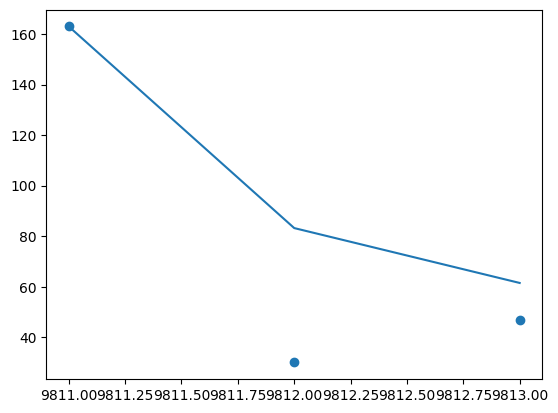

In [8]:
pdf = df.toPandas()
pdf.head()

import matplotlib.pyplot as plt
plt.scatter(pdf['month_bs_id'], pdf['total_txn_cnt'])
plt.plot(pdf['month_bs_id'], pdf['smoothed_txn_cnt']);

### Exponential Smoothing in Pandas

In [9]:
import pandas as pd
import numpy as np

np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=50, freq='D')
sales = np.random.randint(50, 200, size=50)
df = pd.DataFrame({'Date': dates, 'Sales': sales})

def exponential_smoothing(series, alpha):
    result = series.copy()
    result[0] = series[0]  
    for i in range(1, len(series)):
        result[i] = alpha * series[i] + (1 - alpha) * result[i - 1]
    return result
 
smoothing_factor = 0.6
df['Smoothed_Sales'] = exponential_smoothing(df['Sales'], smoothing_factor)

df.head() 

C:\Windows\Temp\ipykernel_4592\1646737528.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '96.80000000000001' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  result[i] = alpha * series[i] + (1 - alpha) * result[i - 1]


,Date,Sales,Smoothed_Sales
0,2023-01-01,152,152.000
1,2023-01-02,142,146.000
2,2023-01-03,64,96.800
3,2023-01-04,156,132.320
4,2023-01-05,121,125.528
